In [1]:
from glob import glob
from os.path import isfile, realpath, dirname
import json
import time
from collections import Counter

import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim, Bing
import reverse_geocode
import folium
import folium.plugins
import countryinfo

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
bingkey = 'YOUR_BING_API_KEY_HERE'

In [75]:
geolocator = Bing(bingkey)

In [82]:
# countryinfo allows you to look up all sorts of stuff by country
# but we want the reverse: Use some of that info (the TLD) to look up the country
# So, go throught the package data and make a dict.
country_data_path = dirname(realpath(countryinfo.__file__))  + '/data/'
country_files = glob(country_data_path + '*.json')
country_from_tld = {}
for fname in country_files:
    with open(fname) as f:
        dat = json.load(f)
        for tld in dat['tld']:
            country_from_tld[tld] = dat['name']

In [207]:
# Two TLDs that are always US and that come up quite often but are not part of 
# the countryinfo package
country_from_tld['.edu'] = 'United States'
country_from_tld['.gov'] = 'United States'

In [86]:
def latlon_from_email(email):
    '''Determine lat/lon from email address
    
    Parameters
    ----------
    email : string
    '''
    tld = '.' + email.split('.')[-1]
    if tld in country_from_tld:
        country = countryinfo.CountryInfo(country_from_tld[tld])
        return country.latlng()
    else:
        return np.nan, np.nan
    
def resolve_from_email(df):
    '''Iterate over pandas dataframe and fill in mepty lat/lon from email'''
    for ind, row in df.iterrows():
        if np.isnan(row['lat']):
            lat, lon = latlon_from_email(row['Email Address'])
            df.loc[ind, 'lat'] = lat
            df.loc[ind, 'lon'] = lon

### First, get countryinfo for Cool Stars 20

In [76]:
# Load participand data from CSV (which is exported form Google forms)
cs20 = pd.read_csv('reglistcs20.csv')
cs20['lat'] = np.nan
cs20['lon'] = np.nan

In [81]:
for ind, row in cs20.iterrows():
    if np.isnan(row['lat']):
        if row['Institution'] is not '':
            out = geolocator.geocode(row['Institution'])
            if out is not None:
                cs20.loc[ind, 'lat'] = out.latitude
                cs20.loc[ind, 'lon'] = out.longitude

In [85]:
# How many position are still unresolved?
np.isnan(cs20['lon']).sum()

32

In [87]:
# Use ending of email address to fill in the remaining countries
resolve_from_email(cs20)
# How many are left?
np.isnan(cs20['lon']).sum()

5

In [88]:
# Save results, so I don't have to re-run the bing search when I re-run this notebook
cs20.to_csv('reglistcs20_latlon.csv')

### Now, for CS 20.5
Note that I write intermediate results to disk, so if a few participants are added to the list and I read a new csv files with those added, I don't have to do the entore reverse look-up again, but I can merge the new csv with the old one. That's not fully automated, because I changed the format occasionally, but I would to nat next time. Just join the dataframes with the look up plus the dataframe witn the new reglist, or just find which ones are new and add those to the dtaframe that has the look-up already.

That's important for two reasons: The reverse look-up is annoyingly slow, sometimes it times out, so you have to re-start in the middle anyway, and we have limited free look-ups, so we don't want to look up the same address many, many times.

In [428]:
cs205 = pd.read_csv('20210302.csv')

In [429]:
cs205['lat'] = np.nan
cs205['lon'] = np.nan

In [433]:
for ind, row in cs205.iterrows():
    if np.isnan(row['lat']):
        if row['Affiliation'] is not '':
            out = geolocator.geocode(row['Affiliation'])
            if out is not None:
                cs205.loc[ind, 'lat'] = out.latitude
                cs205.loc[ind, 'lon'] = out.longitude
            #time.sleep(1.3)

In [434]:
# How mand remain unresolved?
np.isnan(cs205['lon']).sum()

30

In [435]:
#Save for later
cs205.to_csv('20210302_latlon.csv')

In [303]:
# Load in last version, and skip the cells above if I re-run this notebook with a new list
# cs205 = pd.read_csv('20210228_latlon.csv')

In [436]:
for ind, row in cs205.iterrows():
    if np.isnan(row['lat']):
        lat, lon = latlon_from_email(row['Email Address'])
        cs205.loc[ind, 'lat'] = lat
        cs205.loc[ind, 'lon'] = lon


In [437]:
np.isnan(cs205['lat']).sum()

11

In [438]:
# List affiliations that are unresolved. For most of those, I would not know the location either.
cs205['Affiliation'][np.isnan(cs205['lat'])]

79                  MVJCE
103                  IRAP
272                 AAVSO
413                  IRAP
454                  IRAP
563                  UFMG
748     Metauniverse Team
795                  IRAP
1093      Disk Detectives
1095       Disk Detective
1119           zooniverse
Name: Affiliation, dtype: object

In [277]:
# Check formatting
good = ~np.isnan(cs205['lat'])
list(cs205[good]['popups'].to_numpy())

['Justin Kasper - nan',
 'Nikoleta Ilic - Leibniz Institute for Astrophysics Potsdam',
 'Katja Poppenhaeger - Leibniz Institute for Astrophysics Potsdam (AIP)',
 'Monika I. Jurkovic - Astronomical Observatory Belgrade',
 'Alexander Slater Binks - Keele University',
 'Hsien Shang - Institute of Astronomy and Astrophysics, Academia Sinica',
 'Stanimir Metchev - The University of Western Ontario',
 'Loïc Albert - Institut de recherche sur les exoplanètes, Université de Montréal',
 'Thierry Forveille - Observatoire de Grenoble',
 'Kelle Cruz - CUNY - Hunter College',
 'Jeff Valenti - STScI',
 'Jane Pratt - Georgia State University',
 'Thomas Ayres - University of Colorado (CASA)',
 'H. Tuğça Şener  - nan',
 'Travis Metcalfe - WDRC',
 'John Gizis - University of Delaware',
 'Adriana Errico - University of Southern Queensland',
 'UT Ahmed - USQ',
 'Dan Peluso - University of Southern Queensland and the SETI Institute ',
 'Gregory Mace - Univ. or Texas at Austin',
 'Damian Fabbian - Universit

In [444]:
def map_from_reglist(df):
    m = folium.Map(location=[0, 0], zoom_start=2)
    good = ~np.isnan(df['lat']) & ~np.isclose(df['lat'], 18.776562)
    cluster = folium.plugins.MarkerCluster(df[good][['lat', 'lon']].to_numpy(),
                                          popups=list(df[good]['popups']))
    out = cluster.add_to(m)
    return m

In [379]:
cs20

,First Name,Last Name,Institution,Tran#,Email Address,days,group,lat,lon
0,Alessandro,Lanzafame,Universita di Catania,8277,a.lanzafame@unict.it,NaN,NaN,37.558290,15.051890
1,Andres,Moya,University of Birmingham,8667,a.moya@bham.ac.uk,NaN,NaN,52.453522,-1.927474
2,Andreas,Quirrenbach,Landessternwarte,8565,a.quirrenbach@lsw.uni-heidelberg.de,NaN,NaN,51.000000,9.000000
3,Angela,Breimann,University of Exeter,8301,aab222@exeter.ac.uk,NaN,NaN,50.736469,-3.535851
4,Aaron,Dotter,SAO,1000,aaron.dotter@cfa.harvard.edu,Mon,NaN,38.000000,-97.000000
...,...,...,...,...,...,...,...,...,...
523,Zach,Berta-Thompson,University of Colorado,8381,zach.bertathompson@colorado.edu,NaN,NaN,40.007423,-105.266335
524,Eleonora,Zari,Leiden Observatory,8259,zariem@strw.leidenuniv.nl,NaN,NaN,52.154999,4.485000
525,Zenghua,Zhang,"GEPI, Observatoire de Paris",8268,zenghuazhang@gmail.com,NaN,NaN,48.842667,2.336475
526,Zhoujian,Zhang,"Institute for Astronomy, University of Hawaii",8444,zhoujian@hawaii.edu,NaN,NaN,21.296350,-157.816269


In [447]:
cs20['popups'] = cs20[['First Name', 'Last Name']].agg(' '.join, axis=1)
m20 = map_from_reglist(cs20)
m20

In [448]:
m20.save('data/cs20_map.html')

In [441]:
cs205

,Timestamp,Email Address,Publish contact information?,Name,Affiliation,Do you want to submit an abstract for a talk or poster?,Authors,Affiliations,Title,Abstract,...,Offensive / inappropriate content,day,time,haiku number,youtubelink,pdflink,zenodolink,lat,lon,popups
0,11/17/2020 3:29:48,xxx,NaN,Justin Kasper,NaN,yes,Kasper,NaN,Parker Solar Probe,TBD,...,NaN,Wed,12:00,NaN,NaN,NaN,NaN,18.776562,100.774048,Justin Kasper
1,11/17/2020 4:29:48,nilic@aip.de,NaN,Nikoleta Ilic,Leibniz Institute for Astrophysics Potsdam,yes,Nikoleta Ilic\nKatja Poppenhaeger,Leibniz Institute for Astrophysics Potsdam,Measuring the tidal interaction footprint on s...,It is an open question to what degree planets ...,...,NaN,Tue,13:00,6.0,NaN,NaN,NaN,52.373926,13.133819,Nikoleta Ilic
2,11/17/2020 5:08:33,kpoppenhaeger@aip.de,NaN,Katja Poppenhaeger,Leibniz Institute for Astrophysics Potsdam (AIP),yes,Katja Poppenhaeger,Leibniz Institute for Astrophysics Potsdam\nUn...,Helium observations of exoplanet atmospheres a...,Transit observations in the helium lines near ...,...,NaN,Thu,15:00,1.0,NaN,NaN,NaN,52.373926,13.133819,Katja Poppenhaeger
3,11/17/2020 8:16:19,mojur@aob.rs,I agree to publishing my email address on the ...,Monika I. Jurkovic,Astronomical Observatory Belgrade,No,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.817001,20.466999,Monika I. Jurkovic
4,11/17/2020 8:25:44,a.s.binks1@keele.ac.uk,I agree to publishing my email address on the ...,Alexander Slater Binks,Keele University,yes,A. S. Binks (1)\nR. D. Jeffries (1)\nG. G. Sac...,Keele University\nINAF,Pre-Main Sequence Stars: Older and Colder?,I present our recent tests to assess how capab...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.007206,-2.263685,Alexander Slater Binks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,3/2/2021 11:02:13,saar@cfa.harvard.edu,I agree to publishing my email address on the ...,Steven Saar,CfA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.000000,-97.000000,Steven Saar
1198,3/2/2021 11:13:51,tahina@asu.edu,NaN,Tahina Ramiaramanantsoa,Arizona State University,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.421001,-111.932999,Tahina Ramiaramanantsoa
1199,3/2/2021 11:16:18,c.kobayashi@herts.ac.uk,I agree to publishing my email address on the ...,Chiaki Kobayashi,University of Hertfordshire,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.751919,-0.239735,Chiaki Kobayashi
1200,3/2/2021 11:22:34,weipenglew@email.arizona.edu,I agree to publishing my email address on the ...,Ben Lew,University of Arizona,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.232899,-110.950584,Ben Lew


In [439]:
#cs205['popups'] = cs205.agg('{0[Name]}: {0[Affiliation]}'.format, axis=1)
cs205['popups'] = cs205.agg('{0[Name]}'.format, axis=1)
#cs205['popups'] = cs205[['Name', 'Affiliation']].fillna('').agg(': '.join, axis=1)

In [445]:
m205 = map_from_reglist(cs205)
m205

In [446]:
m205.save('data/participant_map.html')

In [451]:
def countryhist(df):
    good = ~np.isnan(df['lat']) & ~np.isclose(df['lat'], 18.776562)
    reversegeo = reverse_geocode.search(df[good][['lat', 'lon']].to_numpy())
    countryhist = Counter([l['country'] for l in reversegeo])
    chist = pd.DataFrame({'country': list(countryhist.keys()), 'n': list(countryhist.values())})
    chist = chist.sort_values('n', ascending=False)
    return chist

In [452]:
def plot_countryhist(chist):
    fig, ax = plt.subplots(figsize=(15, 5))
    ind = chist['n'] > 2
    ax.bar(chist['country'][ind], chist['n'][ind])
    out = plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    ind1 = chist['n'] == 1
    ind2 = chist['n'] == 2

    out = ax.text(0.5, 0.95, '2 attendees\n--------------------\n' + '\n'.join(chist['country'][ind2]),
        horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

    out = ax.text(0.7, 0.95, '1 attendee\n--------------------\n' + '\n'.join(chist['country'][ind1]),
        horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
    ax.set_yscale('log')
    ax.grid(True, 'both', 'y', alpha=.5)
    return fig, ax

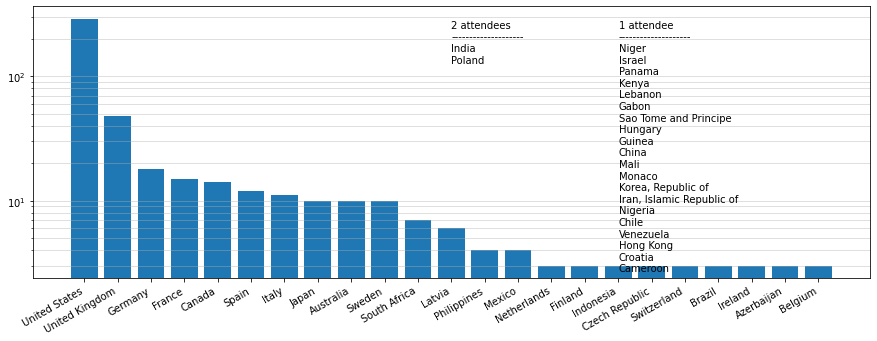

In [454]:
fig, ax = plot_countryhist(countryhist(cs20))
fig.savefig('data/cs20_countries.png')

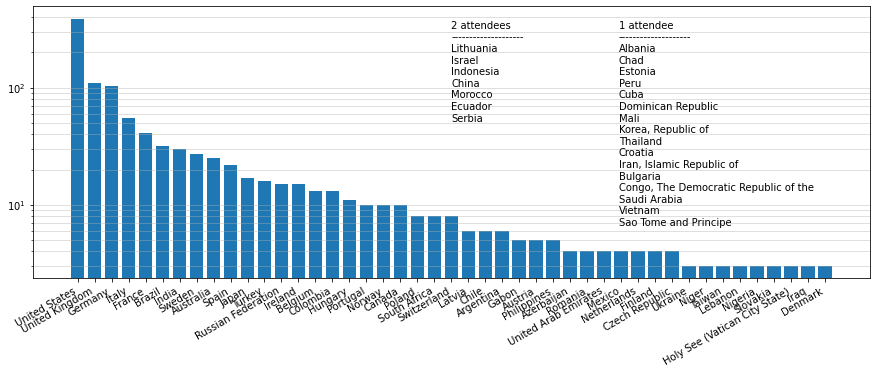

In [455]:
fig, ax = plot_countryhist(countryhist(cs205))
fig.savefig('data/cs205_countries.png')

In [64]:
cs205['Timestamp']

0                     xxx
1      11/17/2020 4:29:48
2      11/17/2020 5:08:33
3      11/17/2020 8:16:19
4      11/17/2020 8:25:44
              ...        
887     2/24/2021 3:39:33
888     2/24/2021 3:45:05
889     2/24/2021 4:10:06
890     2/24/2021 6:35:39
891     2/24/2021 6:47:01
Name: Timestamp, Length: 892, dtype: object

In [68]:
len(cs205)

892

TypeError: 'value' must be an instance of str or bytes, not a float

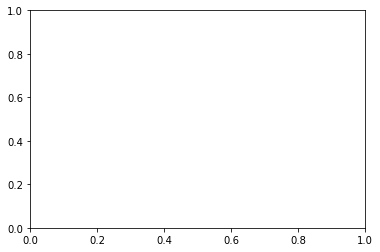

In [66]:
# In this version, one of the timespamps is xxx so it won't work.
plt.plot(cs205['Timestamp'], np.arange(len(cs205)))

# Timing

In [3]:
cs20abs = pd.read_csv('cs20abstracts.csv')

In [4]:
from datetime import datetime

In [5]:
import re
timematcher = re.compile(r'(?P<month>\d+)/(?P<day>\d+)/(?P<year>\d+) (?P<hour>\d+):(?P<minute>\d+):(?P<second>\d+)')

In [6]:
def valtoint(d):
    out = {}
    for k, v in d.items():
        out[k] = int(v)
    return out

In [7]:
submissiontime = [datetime(**valtoint(timematcher.match(r).groupdict())) 
                  for r in cs20abs['Timestamp'][cs20abs['Timestamp'].notnull()]]

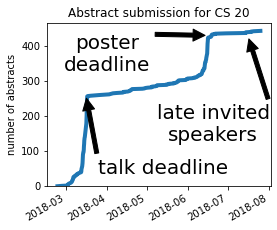

In [8]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(sorted(submissiontime), np.arange(len(submissiontime)), lw=4)
#ax.set_xlabel('date')
ax.set_ylabel('number of abstracts')
ax.set_title('Abstract submission for CS 20')
ax.set_ylim(0, None)
ax.annotate('talk deadline',
            xy=(datetime(2018, 3, 16), 260), xycoords='data',
            xytext=(datetime(2018,7,1), 25), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',
           fontsize=20)

ax.annotate('poster\ndeadline',
            xy=(datetime(2018, 6, 16), 430), xycoords='data',
            xytext=(datetime(2018,4,1), 375), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='center',
           fontsize=20)

ax.annotate('late invited\nspeakers',
            xy=(datetime(2018, 7, 16), 430), xycoords='data',
            xytext=(datetime(2018,6,20), 175), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='center',
           fontsize=20)
out = plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
fig.savefig('timingCS20.pdf')

In [9]:
cs205latest = pd.read_csv('20210304.csv')

In [10]:
registertime205 = [datetime(**valtoint(timematcher.match(r).groupdict())) 
                  for r in cs205latest['Timestamp'][cs205latest['Timestamp'].notnull()]]

In [11]:
abstracttime205 = [datetime(**valtoint(timematcher.match(r).groupdict())) 
                  for r in cs205latest['Timestamp'][cs205latest['Title'].notnull()]]

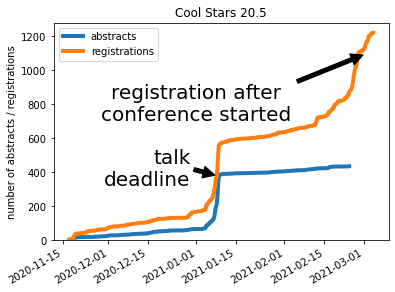

In [13]:
fig, ax = plt.subplots()
ax.plot(sorted(abstracttime205), np.arange(len(abstracttime205)), lw=4, label='abstracts')
ax.plot(sorted(registertime205), np.arange(len(registertime205)), lw=4, label='registrations')
ax.legend()
#ax.set_xlabel('date')
ax.set_ylabel('number of abstracts / registrations')
ax.set_title('Cool Stars 20.5')
ax.set_ylim(0, None)
ax.annotate('talk\ndeadline',
            xy=(datetime(2021, 1, 8), 380), xycoords='data',
            xytext=(datetime(2020, 12, 30), 300), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',
           fontsize=20)

ax.annotate('registration after\nconference started',
            xy=(datetime(2021, 3, 2), 1100), xycoords='data',
            xytext=(datetime(2021, 1, 1), 800), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='center',
           fontsize=20)

out = plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
fig.savefig('timingCS205.pdf')